# Assignment 3 - Lyrics Generations Using Melody
 
### Authors:

1.   Liav Bachar 205888472
2.   Naor Kolet 205533060


# Imports

In [1]:
import pandas as pd
import numpy as np
 
# TensorFlow
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Concatenate
from tensorflow.keras.layers import Dropout, Dense, Lambda
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam


# Scikit-learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

# Text preprocessing
import nltk
from nltk.tokenize import word_tokenize
import re
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Misc.
import os
import joblib
import random
import time
from tqdm import tqdm_notebook as tqdm
import pretty_midi
import datetime

SEED = 42
%matplotlib inline

In [99]:
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Load Data

## Load raw data

First we loads the raw files that were given with the assignment.
Note: Some changes were made to some songs' names to match their midi file name.

In [3]:
cols = ['Singer', 'Song Name', 'Lyrics']

df = pd.read_csv('datasets/lyrics_train_set.csv', names=cols)
df_test = pd.read_csv('datasets/lyrics_test_set.csv', names=cols)

### Remove non rational lyrics

We found one song that does not contain real words in its lyrics so we have decided to remove it from our train dataset

In [4]:
bad_song = df.query("Singer == 'darude'")
bad_song

,Singer,Song Name,Lyrics
315,darude,sandstorm,[instrumental] & du du dudududududuud & dududu...


In [5]:
df.drop(axis=0, index=bad_song.index, inplace=True)

## Add midi files

Here we attach to each song record its associate midi file name to be able to load its melody later in the process

In [6]:
def add_midi_files(df):
    midis = list(os.listdir(r'./datasets/midi_files'))
    midis = {midi.lower()[:-4]: midi for midi in midis}    
    
    def combine_singer_song(singer, song):
        key = f'{singer} - {song}'.replace(' ', '_').lower()
        return midis[key] if key in midis else None
    
    df['Midi File'] = df.apply(lambda r: combine_singer_song(r['Singer'], r['Song Name']) ,axis=1)
    return df

In [7]:
df = add_midi_files(df)
df_test = add_midi_files(df_test)

### check midi files

We found that several midi files are broken and cannot be loaded.
We have decided to remove the associate songs' records from our train data.

In [8]:
midis = np.concatenate([df['Midi File'].values, df_test['Midi File'].values])
midis.shape

(619,)

In [9]:
corrupted = []
for i, midi in enumerate(midis):
    try:
        midi = pretty_midi.PrettyMIDI(fr'./datasets/midi_files/{midi}')
        midi.remove_invalid_notes()
        del midi
    except Exception as e:
        print("%s\nerror readying midi file %s" % (e, midi))
        corrupted.append(i)

/home/naorko/.conda/envs/tf-env/lib/python3.8/site-packages/pretty_midi/pretty_midi.py:97: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Could not decode key with 16 sharps and mode 1
error readying midi file David_Bowie_-_Lazarus.mid
Could not decode key with 1 flats and mode 255
error readying midi file Beastie_Boys_-_Girls.mid
data byte must be in range 0..127
error readying midi file Billy_Joel_-_Movin'_Out.mid
data byte must be in range 0..127
error readying midi file Billy_Joel_-_Pressure.mid
Could not decode key with 4 flats and mode 255
error readying midi file Dan_Fogelberg_-_Leader_of_the_Band.mid

error readying midi file Brian_McKnight_-_On_The_Down_Low.mid
data byte must be in range 0..127
error readying midi file Aaron_Neville_-_Tell_It_Like_It_Is.mid


In [10]:
bad_songs = df.iloc[corrupted]
bad_songs

,Singer,Song Name,Lyrics,Midi File
91,david bowie,lazarus,look up here i'm in heaven & i've got scars th...,David_Bowie_-_Lazarus.mid
115,beastie boys,girls,girls all i really want is girls & and in the ...,Beastie_Boys_-_Girls.mid
136,billy joel,movin' out,anthony works in the grocery store & savin h...,Billy_Joel_-_Movin'_Out.mid
143,billy joel,pressure,you have to learn to pace yourself & pressure ...,Billy_Joel_-_Pressure.mid
189,dan fogelberg,leader of the band,an only child alone and wild a cabinet maker's...,Dan_Fogelberg_-_Leader_of_the_Band.mid
513,brian mcknight,on the down low,maxine was 5'9'' & had a man and she didn't mi...,Brian_McKnight_-_On_The_Down_Low.mid
575,aaron neville,tell it like it is,if you want something to play with & go and fi...,Aaron_Neville_-_Tell_It_Like_It_Is.mid


In [11]:
df.drop(axis=0, index=bad_songs.index, inplace=True)

## Create Validation Dataset

In [12]:
msk = np.random.rand(len(df)) < 0.8

df_train = df[msk]
df_val = df[~msk]

# Preprocessing

Our preprocessing stage divided into two main parts.
 - Lyrics preprocessing
 - Melody preprocessing

## Lyrics Preprocessing

Here we  take the loaded songs' lyrics and process them throw several steps.
1. Brake shortcut phrases e.g. can't --> can not . This step will make the words more meaningful and we will be able to use the pretrained embeddings for this words
2. Remove all non-alphabetical words and punctions, assuming they are not meaningful. Note: We keeping only the character '&' that is represents a new line.
3. Lower case all the words to make it easier to tokenize the same words into the same token
4. Lastly, we add the symbol '$' in the end of each song to represent the song termination.

Note: We did not used stemming of any kind or removed stop words becasue we wanted to preserve the structure of the sentences to be able to generate meaningful sentences

In [13]:
from nltk.tokenize import word_tokenize

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"in\'", "ing", phrase)
    phrase = re.sub(r"y\'all", "you all", phrase)
    phrase = re.sub(r"hiya", "hi you", phrase)
    
    # punctions
    regex = re.compile('[^a-zA-Z& ]')
    phrase = regex.sub('', phrase)
    
    return phrase

def preprocess_lyrics(data):
    data = decontracted(data)
    tokens = word_tokenize(data)
    data_arr = []
    
    for t in tokens:    
        # Lower case word
        t = t.lower()
        
        data_arr.append(t)
    
    
    return data_arr

In [14]:
df_train.iloc[1,2]

"you know i need your love & you've got that hold over me & long as i've got your love & you know that i'll never leave & when i wanted you to share my life & i had no doubt in my mind & and it's been you woman & right down the line & i know how much i lean on you & only you can see & the changes that i've been through & have left a mark on me & you've been as constant as a northern star & the brightest light that shines & it's been you woman right down the line & i just want to say this is my way & of tellin' you everything & i could never say before & yeah this is my way of tellin' you & that every day i'm lovin' you so much more & 'cause you believed in me through my darkest night & put somethin' better inside of me & you brought me into the light & threw away all those crazy dreams & i put them all behind & and it was you woman & right down the line & i just want to say this is my way of tellin' you everything & i could never say before & yeah this is my way of tellin' you & everyt

In [15]:
string = df_train.iloc[1,2]
tokenized_string = preprocess_lyrics(string)

def pretty_lyrics(tokenized_string):
    for token in tokenized_string:
        if token == '&':
            print('\n')
        else:
            print(token, end=' ')

pretty_lyrics(tokenized_string)

you know i need your love 

you have got that hold over me 

long as i have got your love 

you know that i will never leave 

when i wanted you to share my life 

i had no doubt in my mind 

and it is been you woman 

right down the line 

i know how much i lean on you 

only you can see 

the changes that i have been through 

have left a mark on me 

you have been as constant as a northern star 

the brightest light that shines 

it is been you woman right down the line 

i just want to say this is my way 

of telling you everything 

i could never say before 

yeah this is my way of telling you 

that every day i am loving you so much more 

cause you believed in me through my darkest night 

put something better inside of me 

you brought me into the light 

threw away all those crazy dreams 

i put them all behind 

and it was you woman 

right down the line 

i just want to say this is my way of telling you everything 

i could never say before 

yeah this is my way of telling y

In [100]:
stop_token = '$'
lyrics_train = df_train['Lyrics'].apply(lambda s: preprocess_lyrics(s)[:-1] + [stop_token])
lyrics_val = df_val['Lyrics'].apply(lambda s: preprocess_lyrics(s)[:-1] + [stop_token])

### Load embeddings

Here we manage to load pre-trained embeddings for our words of the songs.
We first create a dictionary using a built-in Tokenizer that maps each word to a unique number.
Then we create an embeddings matrix of size (Dictionary-size x Embeddings-size) where each row will contain the embedding from google that matches the word from the dictionary.

In [17]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(lyrics_train)

In [101]:
lyrics_train = tokenizer.texts_to_sequences(lyrics_train)
lyrics_val = tokenizer.texts_to_sequences(lyrics_val)

In [19]:
EMBEDDING_FILE = './GoogleNews-vectors-negative300.bin'

if not os.path.isfile(EMBEDDING_FILE):
    !wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
    !gzip -f -d GoogleNews-vectors-negative300.bin.gz

In [20]:
from gensim import models

embeddings_index = models.KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)
embed_size = 300
word_index = tokenizer.word_index
max_features = len(word_index) + 1

nb_words = len(word_index)
embedding_matrix = (np.random.rand(nb_words+1, embed_size) - 0.5) / 5.0

not_in_word2vec = 0
for word, i in word_index.items():
    if i >= max_features: continue
    if word in embeddings_index:
        embedding_vector = embeddings_index.get_vector(word)
        embedding_matrix[i] = embedding_vector
    else:
        not_in_word2vec += 1
        
print(f'{not_in_word2vec} out of {len(word_index)} has no embedings from word2vec')

414 out of 6160 has no embedings from word2vec


### Spliting songs into sliding window of fixed size

Here we split each song into slided windows. Each window will be of fixed size and our model will try to predict the next word given a window.

In [21]:
ast=np.lib.index_tricks.as_strided
def generate_sliding_window(arr, window_size=5, window_stride=1, last_window=False):
    last_window = 1 if last_window else 0
    arr = np.ascontiguousarray(arr)
    arr_len = arr.shape[0]
    s, = arr.strides
    windows_num = ((arr_len-window_size)//window_stride) + last_window
    
    return ast(arr, (windows_num, window_size), (s*window_stride, s))

In [22]:
def split_lyrics(lyrics, window_size=10):
    X, y = [], []
    for lyric in lyrics:
        X.append(generate_sliding_window(lyric, window_size))
        y.append(to_categorical(lyric[window_size:], num_classes=max_features))
        
    return X, y


In [102]:
window_size = 10
lyrics_train = split_lyrics(lyrics_train, window_size)
lyrics_val = split_lyrics(lyrics_val, window_size)

## Melody preprocessing

Here we implemented two different ways to process the midi files:
1. `whole` - Take the piano roll of the midi file and calculate the average value of each note across the whole song.
2. `slided` - Take the piano roll and slice it into sliding windows which represents the notes that being played during one word, each window will be attached to the corresponding word in the song.

### Check Melody's Notes Values Range

In [28]:
midis = np.concatenate([df['Midi File'].values, df_test['Midi File'].values])
fs = 5

max_note_val = -1
min_frames = 9999
max_frames = -1
for midi in tqdm(midis):
    pm = pretty_midi.PrettyMIDI(fr'./datasets/midi_files/{midi}')
    pm.remove_invalid_notes()
    
    piano_roll = pm.get_piano_roll(fs=fs)
    if piano_roll.shape[1]:
        curr_len = piano_roll.shape[1]
        min_frames = min(min_frames, curr_len)
        max_frames = max(max_frames, curr_len)
        
    for inst in pm.instruments:
        piano_roll = inst.get_piano_roll(fs=fs)
        if piano_roll.shape[1]:
            curr_max_note = piano_roll.max()
            max_note_val = max(max_note_val, curr_max_note)
        
    del pm

print(f'The maximum note value is {max_note_val}')
print(f'The minimum song length is {min_frames}')
print(f'The maximum song length is {max_frames}')

/home/naorko/.conda/envs/tf-env/lib/python3.8/site-packages/pretty_midi/pretty_midi.py:97: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(



The maximum note value is 762.0
The minimum song length is 297
The maximum song length is 3006


### Preprocess Entire Melody into a Single Vector

In [86]:
def preprocess_melody_file_whole(midi_name, fs=5, max_piano_val=100):
    pm = pretty_midi.PrettyMIDI(fr'./datasets/midi_files/{midi_name}')
    pm.remove_invalid_notes()
    
    # Sum all notes from all instruments
    piano_all = pm.get_piano_roll(fs=fs)
    piano_shape = piano_all.shape

    # Normalize by the number of played instruments in the same time and note
    counter = np.zeros(piano_shape)
    for inst in pm.instruments:
        curr_piano = inst.get_piano_roll(fs=fs)

        counter[:, :curr_piano.shape[1]] += (curr_piano > 0).astype(int)

    counter[counter == 0] = 1
    piano_all /= counter
    
    # Normalize by the maximum value of a note
    piano_all = piano_all / max_piano_val
    
    # Normalize by the number of played notes in the same time
    count_notes = (piano_all > 0).sum(axis=1)
    count_notes[count_notes == 0] = 1
    melody = piano_all.sum(axis=1) / count_notes
    
    return melody

In [ ]:
melody_train_whole = df_train['Midi File'].apply(preprocess_melody_file_whole, fs=100, max_piano_val=762)
melody_val_whole = df_val['Midi File'].apply(preprocess_melody_file_whole, fs=100, max_piano_val=762)

Here we attach the same single vector representation of the melody to each word of the song

In [29]:
def prepare_x_y_whole(lyrics, melody):
    for i in range(len(lyrics[0])):
        window_n, window_size = lyrics[0][i].shape
        
        melody.iloc[i] = np.repeat([melody.iloc[i]], repeats=window_n * window_size).reshape(window_n, window_size, -1)
        
            
    lyrics_X = np.concatenate(lyrics[0])
    lyrics_y = np.concatenate(lyrics[1])
    melody = np.concatenate(melody.values)
            
    return (melody, lyrics_X), lyrics_y

In [104]:
train_data_whole = prepare_x_y_whole(lyrics_train, melody_train_whole)
val_data_whole = prepare_x_y_whole(lyrics_val, melody_val_whole)

### Preprocess Melody into a Sliding Window of Notes

In [34]:
ast=np.lib.index_tricks.as_strided
def generate_sliding_window_2d(arr, window_size=5, window_stride=1, last_window=False):
    last_window = 1 if last_window else 0
    arr = np.ascontiguousarray(arr)
    l0, l1 = arr.shape
    s0, s1 = arr.strides
    windows_num = ((l0-window_size)//window_stride) + last_window
    
    return ast(arr, (windows_num, window_size, l1), (s0*window_stride, s0, s1))

In [105]:
def preprocess_melody_file_slided(midi_name, fs=5, max_piano_val=100, fpw=4, window_size=10):
    pm = pretty_midi.PrettyMIDI(fr'./datasets/midi_files/{midi_name}')
    pm.remove_invalid_notes()
    
    # Sum all notes from all instruments
    piano_all = pm.get_piano_roll(fs=fs)
    piano_shape = piano_all.shape

    # Normalize by the number of played instruments in the same time and note
    counter = np.zeros(piano_shape)
    for inst in pm.instruments:
        curr_piano = inst.get_piano_roll(fs=fs)

        counter[:, :curr_piano.shape[1]] += (curr_piano > 0).astype(int)

    counter[counter == 0] = 1
    piano_all /= counter
    
    # Normalize by the maximum value of a note
    piano_all = piano_all / max_piano_val
    
    # Normalize by the number of played notes in the same time
    count_notes = (piano_all > 0).sum(axis=0)
    count_notes[count_notes == 0] = 1
    melody = piano_all.sum(axis=0) / count_notes
    del piano_all
    
    # Split Melody's notes into words
    melody_per_word = generate_sliding_window(melody[(melody > 0).argmax():], window_size=fpw, window_stride=(fpw*4)//5, last_window=True)
    # Split Melody's words into windows
    melody_windows = generate_sliding_window_2d(melody_per_word, window_size=window_size, last_window=True)
    
    return melody_windows

Notes regarding the parameters:
- **fs**: is the frequency, at frequency 100, each second will be splitted into 100 frames, each frame will contain the value of the notes that were played during it
- **fpw**: is frames per word, according to our research, each word takes about 64 miliseconds. We assigned for each word 100 miliseconds were each "word" of melody will overlap the other about 20%. We established the ovelaps because we assumed that some words take less time than others so it will cover it up and indeed we saw improvement in the performance with this technique

In [106]:
melody_train_slided = df_train['Midi File'].apply(preprocess_melody_file_slided, fs=100, max_piano_val=762, fpw=100, window_size=10)
melody_val_slided = df_val['Midi File'].apply(preprocess_melody_file_slided, fs=100, max_piano_val=762, fpw=100, window_size=10)

Here we attach the melody's word of notes to the relevent word from the song

In [60]:
def prepare_x_y_slided(lyrics, melody):
    for i in range(len(lyrics[0])):
        mel_len = melody.iloc[i].shape[0]
        lyr_len = lyrics[0][i].shape[0]
        
        if mel_len >= lyr_len:
            melody.iloc[i] = melody.iloc[i][:lyr_len, :, :]
        else:
            lyrics[0][i] = lyrics[0][i][:mel_len, :]
            lyrics[1][i] = lyrics[1][i][:mel_len, :]
            
    lyrics_X = np.concatenate(lyrics[0])
    lyrics_y = np.concatenate(lyrics[1])
    del lyrics
    melody = np.concatenate(melody.values)
            
    return (melody, lyrics_X), lyrics_y

In [107]:
train_data_slided = prepare_x_y_slided(lyrics_train, melody_train_slided)
val_data_slided = prepare_x_y_slided(lyrics_val, melody_val_slided)

# Building the Lyrics Generator model

## Model Architecture

Here we build our model architecture. It contains 4 main parts.

1. **Embedding Layer** - Here the words of each song will be converted to their embeddings representations. We made this layer trainable, let the model learn the embeddings for the missing words.
2. **Concatenate Layer** - Here we attach for each word entry the related melody record
3. **LSTM Layers** - Here we created two layers of lstm, the first one learn features across the windows and outputs all the hidden states, the next one gets those hidden states and output a single feature that was learnt from them.
4. **Softmax Layer** - Give each word in our dictionary the probabilty it will be the next word after the window.

Note: We are using Dropout layers in order to reduce the overfitting

In [45]:
def init_model(window_size, melody_features):
    input_melody = Input(shape=(window_size, melody_features), name='melody')
    input_lyrics = Input(shape=(window_size,), name='lyrics')
    
    embd_lyrics = Embedding(max_features, 
                      embed_size, 
                      weights=[embedding_matrix],
                      input_length=window_size,
                      name='word_embd')(input_lyrics)
    
    merged = Concatenate(axis=2, name='merge')([embd_lyrics, input_melody])
    
    lstm = LSTM(64, return_sequences=True, dropout=0.5)(merged)
    lstm = LSTM(64, dropout=0.5)(lstm)

    X = Dense(128, activation="relu")(lstm)
    X = Dropout(0.5)(X)
    out = Dense(max_features, activation="softmax", name = 'out')(X)

    model = Model([input_melody, input_lyrics], out)

    model.compile(loss='categorical_crossentropy', optimizer=Adam())
    
    return model

In [41]:
model = init_model(*train_data_slided[0][0].shape[1:])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
lyrics (InputLayer)             [(None, 10)]         0                                            
__________________________________________________________________________________________________
word_embd (Embedding)           (None, 10, 300)      1848300     lyrics[0][0]                     
__________________________________________________________________________________________________
melody (InputLayer)             [(None, 10, 100)]    0                                            
__________________________________________________________________________________________________
merge (Concatenate)             (None, 10, 400)      0           word_embd[0][0]                  
                                                                 melody[0][0]                 

## Training Framework

In [42]:
def get_callbacks(model_name):
    acc = 'val_loss'
    acc_mode = 'min'
    
    checkpoint = ModelCheckpoint(
                              fr'./models/{model_name}.h5', 
                              monitor=acc, 
#                               verbose=1, 
                              save_best_only=True, 
                              mode=acc_mode)
    earlystop = EarlyStopping(monitor=acc, mode=acc_mode, verbose=1, patience=6)
    reduceLR = ReduceLROnPlateau(monitor = 'val_loss', mode = 'min', patience = 5,
                            factor = 0.5, min_lr = 1e-6, verbose = 1)

    return [checkpoint, reduceLR, earlystop]

In [43]:
def train_model(model_name, model_gen, train_data, val_data, use_saved=False, params_dict=None):
    os.makedirs('./models', exist_ok=True)
    params = ''
    if params_dict is not None:
        params = '_'.join(f'{key}_{val}' for key,val in params_dict.items())
    model_name = model_gen.__name__[5:] + f'_{model_name}' + f'_{params}'
        
    if use_saved:
        history = joblib.load(fr'./models/{model_name}_history.sav')
    else:
        callbacks = get_callbacks(model_name)
        
        train_x, train_y = train_data
        
        model = model_gen(*train_x[0].shape[1:]) # melody size
        history = model.fit(
                            x=train_x,
                            y=train_y,
                            batch_size=params_dict['batch_size'],
                            epochs=params_dict['epochs'],
                            validation_data=val_data,
                            callbacks=callbacks,
                            verbose=1
                            )
        
        history = history.history
        joblib.dump(history, fr'./models/{model_name}_history.sav')
    
    model = load_model(fr'./models/{model_name}.h5')
    
    return model, history

In [47]:
def visualize_perf(history):
    ncols = 1
    fig, ax = plt.subplots(ncols=ncols, figsize=(5*ncols,5))
    fig.suptitle(f'Model performance over epochs')
    
    for k in ['val_loss', 'loss']:
        ax.plot(history[k])
        
    ax.legend(['val_loss', 'train_loss'])
    ax.margins(0.01)
    ax.set_title('binary crossentropy')
    
    plt.show()

## Model Learning

### 'whole' 

In [91]:
params_dict = {'batch_size': 32, 'epochs': 20}
model_whole, history_whole = train_model('whole', init_model, train_data_whole, val_data_whole, use_saved=False, params_dict=params_dict)

Epoch 1/20
4499/4499 [==============================] - 127s 28ms/step - loss: 5.5997 - val_loss: 5.0700 - lr: 0.0010
Epoch 2/20
4499/4499 [==============================] - 119s 27ms/step - loss: 5.1497 - val_loss: 4.8622 - lr: 0.0010
Epoch 3/20
4499/4499 [==============================] - 118s 26ms/step - loss: 4.9192 - val_loss: 4.7733 - lr: 0.0010
Epoch 4/20
4499/4499 [==============================] - 119s 26ms/step - loss: 4.7693 - val_loss: 4.7468 - lr: 0.0010
Epoch 5/20
4499/4499 [==============================] - 122s 27ms/step - loss: 4.6610 - val_loss: 4.7401 - lr: 0.0010
Epoch 6/20
4499/4499 [==============================] - 121s 27ms/step - loss: 4.5868 - val_loss: 4.7390 - lr: 0.0010
Epoch 7/20
4499/4499 [==============================] - 122s 27ms/step - loss: 4.5269 - val_loss: 4.7534 - lr: 0.0010
Epoch 8/20
4499/4499 [==============================] - 116s 26ms/step - loss: 4.4806 - val_loss: 4.7458 - lr: 0.0010
Epoch 9/20
4499/4499 [==============================] - 

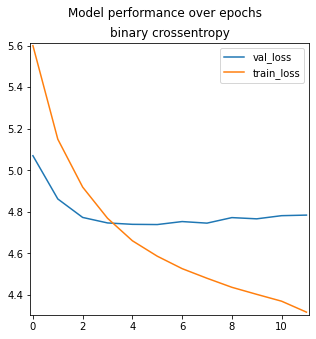

In [92]:
visualize_perf(history_whole)

### 'Slided window'

In [108]:
params_dict = {'batch_size': 32, 'epochs': 20}
model_slided, history_slided = train_model('slided', init_model, train_data_slided, val_data_slided, use_saved=False, params_dict=params_dict)

Epoch 1/20
3428/3428 [==============================] - 87s 25ms/step - loss: 5.6211 - val_loss: 5.1409 - lr: 0.0010
Epoch 2/20
3428/3428 [==============================] - 86s 25ms/step - loss: 5.1992 - val_loss: 4.9118 - lr: 0.0010
Epoch 3/20
3428/3428 [==============================] - 86s 25ms/step - loss: 4.9734 - val_loss: 4.8022 - lr: 0.0010
Epoch 4/20
3428/3428 [==============================] - 94s 27ms/step - loss: 4.8156 - val_loss: 4.7649 - lr: 0.0010
Epoch 5/20
3428/3428 [==============================] - 87s 25ms/step - loss: 4.7033 - val_loss: 4.7466 - lr: 0.0010
Epoch 6/20
3428/3428 [==============================] - 86s 25ms/step - loss: 4.6126 - val_loss: 4.7417 - lr: 0.0010
Epoch 7/20
3428/3428 [==============================] - 97s 28ms/step - loss: 4.5381 - val_loss: 4.7470 - lr: 0.0010
Epoch 8/20
3428/3428 [==============================] - 86s 25ms/step - loss: 4.4798 - val_loss: 4.7611 - lr: 0.0010
Epoch 9/20
3428/3428 [==============================] - 85s 25ms

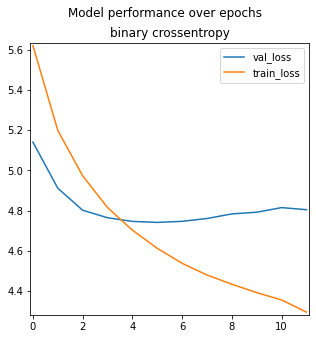

In [109]:
visualize_perf(history_slided)

# Sample Lyrics by Seed - Test Phase

In [49]:
def generate_song(model, seed, window_size, stop_token, tokenizer, max_len):
    stop_token = tokenizer.word_index[stop_token]
    
    def get_next_word(seed):
        probs = model(seed, training=False)
        chosen_idx = np.random.choice(range(0, max_features), p=probs[0])
        chosen_word = tokenizer.sequences_to_texts([[chosen_idx]])[0]
        
        return chosen_idx, chosen_word
    
    
    seed = preprocess_lyrics(seed)
    song = seed.copy()
    seed = ' '.join(seed)
    seed = tokenizer.texts_to_sequences([seed])
    seed = pad_sequences(seed, maxlen=window_size)

    i = 0
    idx, word = get_next_word(seed)
    while word != stop_token and i < max_len:
        song.append(word)
        i+=1
        seed = np.concatenate([seed[:,1:], [[idx]]], axis=1)
        idx, word = get_next_word(seed)
    
    return song    

In [50]:
df_test

,Singer,Song Name,Lyrics,Midi File
0,the bangles,eternal flame,close your eyes give me your hand darling & do...,The_Bangles_-_Eternal_Flame.mid
1,billy joel,honesty,if you search for tenderness & it isn't hard t...,Billy_Joel_-_Honesty.mid
2,cardigans,lovefool,dear i fear we're facing a problem & you love ...,Cardigans_-_Lovefool.mid
3,aqua,barbie girl,hiya barbie & hi ken! & do you want to go for ...,Aqua_-_Barbie_Girl.mid
4,blink 182,all the small things,all the small things & true care truth brings ...,Blink_182_-_All_the_Small_Things.mid


In [78]:
def generate_song_with_melody(model, model_type, lyrics_seed, midi_name, window_size, tokenizer, max_len, fpw=100, stop_token='$'):
    stop_token_idx = tokenizer.word_index[stop_token]
    if model_type == 'slided':
        melody = preprocess_melody_file_by_time(midi_name, fs=100, max_piano_val=762, fpw=fpw, window_size=window_size)
    else:
        melody = preprocess_melody_file_by_note(midi_name, fs=100, max_piano_val=762)
        melody = np.repeat([melody], repeats=window_size, axis=0)
        melody = np.expand_dims(melody, axis=0)
    
    def get_next_word(lyrics_seed, melody_seed):
        if melody_seed is None:
            return stop_token_idx, stop_token
        try:
            probs = model((melody_seed, lyrics_seed), training=False)
            probs_v = np.array(probs[0])
            chosen_idx = np.random.choice(range(0, max_features), p=probs_v)
            chosen_word = tokenizer.sequences_to_texts([[chosen_idx]])[0]
            
        except Exception as e:
            print(e)
            return stop_token_idx, stop_token
        
        return chosen_idx, chosen_word
    
    def get_melody_seed(word_cnt):
        if model_type == "whole":
            return melody
        
        if word_cnt - window_size >= melody.shape[0]:
            return None
        
        if word_cnt < window_size:
            melody_seed = np.concatenate([np.zeros((window_size-word_cnt,fpw)),melody[0][:word_cnt,:fpw]])
        else:
            window_idx = word_cnt-window_size
            
            if window_idx >= melody.shape[0]: # Melody has ended
                return None
            
            melody_seed = melody[window_idx]
        
        return np.expand_dims(melody_seed, axis=0)
    
    
    lyrics_seed = preprocess_lyrics(lyrics_seed)
    song = lyrics_seed.copy()
    lyrics_seed = ' '.join(lyrics_seed)
    lyrics_seed = tokenizer.texts_to_sequences([lyrics_seed])
    word_cnt = len(lyrics_seed[0])
    lyrics_seed = pad_sequences(lyrics_seed, maxlen=window_size)

    melody_seed = get_melody_seed(word_cnt)
    idx, word = get_next_word(lyrics_seed, melody_seed)
    
    while idx != stop_token_idx and word_cnt < max_len:
        song.append(word)
        word_cnt+=1
        lyrics_seed = np.concatenate([lyrics_seed[:,1:], [[idx]]], axis=1)
        melody_seed = get_melody_seed(word_cnt)
        idx, word = get_next_word(lyrics_seed, melody_seed)
    
    return song    

In [79]:
def apply_gen_song(midi_name, model, model_type, lyrics_seed,  window_size=10, song_max_length=100, fpw=100):
    print(f'\n[Song: {midi_name}, seed: {lyrics_seed}]\n')
    song = generate_song_with_melody(model, model_type, lyrics_seed, midi_name, window_size, tokenizer, song_max_length, fpw=fpw)
    pretty_lyrics(song)
    print('\n')


### Generation of 'Whole' architecture

#### Original first word

In [94]:
_ = df_test.apply(lambda r: apply_gen_song(r['Midi File'], model_whole, 'whole', r['Lyrics'].split(' ')[0]), axis=1)


[Song: The_Bangles_-_Eternal_Flame.mid, seed: close]

close 

street and hot lost 

then as tonight 

baby and i see i 

the shot long where we will not it play 

your 

lord we lose my 

wide 

i start if the dance we got on just wan na pull 

give my look to you wrong girl 

maybe if that i am hoes with the doubt is where to do 

c shepherd uh blmchen 

girls says if he is bad motherfucker yeah 


[Song: Billy_Joel_-_Honesty.mid, seed: if]

if oh till buy the where you may make me dre 

suddenly since i do not lose your pleasing darkness 

and are a poison gun clouds 

you are words bad 

aladdin it is all clothes 

the leaves say did what do now 

baby this no i see you when it should call 

you hold around up 

we used to be town 

when you will be married you you see 

but come in anyone look my breath 

you listen into the 

someone takes my string 

oh it ai 


[Song: Cardigans_-_Lovefool.mid, seed: dear]

dear 

i do not breathe when you have a band 

and would he me what i lo

#### First Word - 'Hello'

In [93]:
_ = df_test['Midi File'].apply(lambda midi_name: apply_gen_song(midi_name, model_whole, 'whole', 'Hello'))


[Song: The_Bangles_-_Eternal_Flame.mid, seed: Hello]

hello 

pull no daffodils and mondays the baby the fire 

where now money not all she 

two ladies 

now that i would runaway 

you mean is here 

and we should be mine 

i never am watched suppper law on your earth in town 

someone came now off the ye heads 

she we knew to care you see it show no the obsession and that control me 

and he was gon na am each life 

my dance was there in the want oh i am how for those mc my 


[Song: Billy_Joel_-_Honesty.mid, seed: Hello]

hello 

please decided out a heart how sweet mess 

more shiny yeah 


[Song: Cardigans_-_Lovefool.mid, seed: Hello]

hello 

bout that pain a plan heaven dead 

and they have knew me 

hey 

as and love after but away to follow 

i got this the dewfall that i was like she bad 

but we am a amon pass away down 

does you so divorce just because i will become help you 

do not stay our think but now we loved me strong so hard in you more on alone 

so how my firs

#### First Word - 'World'

In [96]:
_ = df_test['Midi File'].apply(lambda midi_name: apply_gen_song(midi_name, model_whole, 'whole', 'World'))


[Song: The_Bangles_-_Eternal_Flame.mid, seed: World]

world 

all i how your might finally with white on world 


[Song: Billy_Joel_-_Honesty.mid, seed: World]

world 

night manner again 

full places 

midnight pissed this ya should get 

you got 

we get on standing we can so lay ahead 

there is all holding away still me 

it does you get through away 

so hold my love 

on you 

all right our man 

do not leave you i may talk as no trouppper 

do not forget the air when we hear a walk for my shadys 

as you always start hey up with and radio but be games 

but you got my guy 


[Song: Cardigans_-_Lovefool.mid, seed: World]

world 

it got all silver down 

when i only have born my 

carry my death 

when she ai not 

all the good unfurl 

yeah baby leave it what you can make the body 

you could wait in his night 

how here of you 

night with your broken lover 

no honey i can all anybody 

that i am 

just the fight i are a girlfriend of straight 

watch the dreams breaks to th

#### First Word - 'Goodbye'

In [98]:
_ = df_test['Midi File'].apply(lambda midi_name: apply_gen_song(midi_name, model_whole, 'whole', 'Goodbye'))


[Song: The_Bangles_-_Eternal_Flame.mid, seed: Goodbye]

goodbye 

but me semester the are animal tumble all 

oh and we fought the fall 

when it had all bag on me twist or stand on it the sea 

well i will forever you all through everything without you 

i am the poison attitude 

through the boys about my quiet we got me 

watch it at hip to up 

beauty words and niggas you found 

them grow she free do you ever better a name 

rock his fate 

we am wasting to the pedestal 

but i said a 


[Song: Billy_Joel_-_Honesty.mid, seed: Goodbye]

goodbye 

come the scene 

my 

lean on a pride is high 

everything does you stay 

and the year line 

where i can go out so it you think that i can only wan na be here 

when there is just blind that i think to work you 

if the still in the daa to switch in friends 

and still all ta fifty waste 

we so clubs through 

well why is you far in young till down two 

they wanted i am have her stranger 

now why just 


[Song: Cardigans_-_Lovefool.m

### 'Slided Window'

#### Original first word

In [65]:
_ = df_test.apply(lambda r: apply_gen_song(r['Midi File'], model_slided, 'slided', r['Lyrics'].split(' ')[0]), axis=1)


[Song: The_Bangles_-_Eternal_Flame.mid, seed: close]

close of the blues 

and sadness burns like my body 

princess just telling me the song still reach a plan 

i am a government shining where 

you even seen you feeling 

forever i am you 

an look a love must do me more 

and caught back to me why blame the follow so fun 

if you have walk 

darkness as us girl where you do not do not just have laughing 

let me find the you oh lose me girl 

and the claus is 

te rhythm each two 


[Song: Billy_Joel_-_Honesty.mid, seed: if]

if the then wan na see me 

sadness ought it to the road 

we always mean 

my goodbye wishing it is so 

when 

the be around his watching balloon 

all there that there makes de vain 

whoa when dreams gets hours in a we wave again you started 

but hold in our long can all i say 

i want to not love and it is you summer 

and feeling used to prove your breath all the years think i want 

they really have a brand christmas 

do you 


[Song: Cardigans_-_Lov

#### First Word - 'Hello'

In [64]:
_ = df_test['Midi File'].apply(lambda midi_name: apply_gen_song(midi_name, model_slided, 'slided', 'Hello'))


[Song: The_Bangles_-_Eternal_Flame.mid, seed: Hello]

hello 

pa less oh 

had my photograph the springtime is clearing 

i know we need i am so been waiting right 

i have waiting back for the black move 

i will think that is a town that tried 

show to play up through me 

oh 

ooo do not 

ai not come will leave it mellow than beautiful 

where i feel a made em do 

wan na got a light or gold 

and that is all think is big faith 

but all there is the trees 

aladdin 


[Song: Billy_Joel_-_Honesty.mid, seed: Hello]

hello 

i will be hurting me 

only tears i left to say 

it do not give to me 

hear 

just not part to your own 

i was me like the government hot 

as dawn of under the storm 

but i am gon na fly like the road 

the story i miss i will work 

and the power ago 

he is gon na hear up between the tears of why 

there is one stuff dear in a sunshine 

oh let your world da is on me 

crazy 


[Song: Cardigans_-_Lovefool.mid, seed: Hello]

hello 

her pen so coal 

who 

#### First Word - 'World'

In [110]:
_ = df_test['Midi File'].apply(lambda midi_name: apply_gen_song(midi_name, model_slided, 'slided', 'World'))


[Song: The_Bangles_-_Eternal_Flame.mid, seed: World]

world 

every ai you eat dancing or but i ever take you is 

ooo would alone and all that the root of hiding that that had 

and i am no here then you are through 

hold you ten once 



things if it does you like you nobody make the love the hear can good near 

i could tell it 


[Song: Billy_Joel_-_Honesty.mid, seed: World]

world 

again on 

to you made to feel myself 

can not do you know i said all that please hear 

set me young being on 

and a faded filled 

there is a heart me shape 

so time me sees our mind 

it is you think it is a charms 

you know those one enough 


[Song: Cardigans_-_Lovefool.mid, seed: World]

world 

save it away my sweet is hat 

and i could always 

if i tell you up it though i am is killing in the black lives 

but you will lost someone how is my years trouppper on wrong 

i can put my 

and nothing 

me yeah now for the floor 

a sunglasses her frightening 

they will never let the battle as

#### First Word - 'Goodbye'

In [111]:
_ = df_test['Midi File'].apply(lambda midi_name: apply_gen_song(midi_name, model_slided, 'slided', 'Goodbye'))


[Song: The_Bangles_-_Eternal_Flame.mid, seed: Goodbye]

goodbye 

the world eyes talk when only come and turned 

brenda 

maria you looked with bored 

need broadway of nothing take a wall 

cut you my thang are know i love 

am a dark 

shoot nowhere la from as mack queen 

grease run them because that is far stand 

i am easy romance 

what the aim would part 

on the love day girl woo crawl way oh strong no 

oh i remember for the pain 

do it tell it let me face it of another right 




[Song: Billy_Joel_-_Honesty.mid, seed: Goodbye]

goodbye are stars 

and i is so shady to go from a york attitude 

here da daa 

abacab his old caught hookah gave to care 

i are a turn 

who is we met love now 

and i can not be the could no there i have still 

please wan na matter tonight 

and how say i can not come up you all here 

and if no good much to there is a soul 

i am a dee 

silence door more ooh 

you get got alone you will be 


[Song: Cardigans_-_Lovefool.mid, seed: Goodbye]

g